# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import pandas as pd
import zipfile 
import glob
import os
import numpy as np
import pandas as pd
import urllib
import requests
import os
import io
import pylab as plt
import collections 
import geopandas as gpd
from fiona.crs import from_epsg
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist, pdist
#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

In [2]:
allfilezip = glob.glob("*.zip")
allfilezip

[]

In [3]:
for i in allfilezip:
    os.system('mv ' + i + ' $PUIDATA')

In [4]:
#get all unzipped data file names
os.chdir(os.getenv('PUIDATA'))
allfile = glob.glob("zbp*.zip")
allfile

['zbp11totals.zip',
 'zbp08totals.zip',
 'zbp06totals.zip',
 'zbp99totals.zip',
 'zbp13totals.zip',
 'zbp03totals.zip',
 'zbp14totals.zip',
 'zbp04totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp98totals.zip',
 'zbp94totals.zip',
 'zbp10totals.zip',
 'zbp02totals.zip',
 'zbp12totals.zip',
 'zbp07totals.zip',
 'zbp01totals.zip',
 'zbp09totals.zip',
 'zbp00totals.zip',
 'zbp97totals.zip',
 'zbp05totals.zip']

In [5]:
cbb = pd.DataFrame()

In [6]:
for i in range(94,100):
    fname='zbp' + str(i) + 'totals.zip'
    time = 1900 + i
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    cbb = cbb.append(df)
    

for i in range(0,15):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    time = 2000 + i
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    cbb = cbb.append(df)
    
cbb.shape

(828791, 3)

In [7]:
cbb.rename(columns={"ZIP":"ZIPCODE"}, inplace=True)
cbb.head()

,ZIPCODE,EST,YEAR
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


In [8]:
#url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
#urllib.request.urlretrieve(url, "file.gz")
#!unzip -d $PUIDATA file.gz

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [9]:
import geopandas as gpd
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
nyczipsshp['ZIPCODE']=nyczipsshp['ZIPCODE'].values.astype(int)
nyczipsshp = nyczipsshp[['ZIPCODE','geometry']]
#nyczipsshp.dropna(inplace=True)
#nyczipsshp.plot()
#nyczipsshp = nyczipsshp.drop_duplicates("ZIPCODE")
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [10]:
type(nyczipsshp.ZIPCODE[2])

numpy.int64

In [11]:
cbb = pd.pivot_table(cbb, values='EST', index='ZIPCODE', columns='YEAR' )
#cbb.dropna(axis=0, inplace=True)
cbb.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,7.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [12]:
# 20 years of data and 263 zipcodes
cbs = nyczipsshp.merge(cbb,right_index=True, left_on="ZIPCODE")
cbs.drop('geometry',axis=1, inplace=True)
cbs.set_index('ZIPCODE',inplace=True)
cbs.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [13]:
cbs.shape

(260, 21)

In [14]:
#cleaning all missing values
cbs.dropna(axis=0,inplace=True)
cbs.shape

(243, 21)

In [15]:
#then the standardization will look like:
vals = ((cbs.T - cbs.mean(axis=1)) / cbs.std(axis=1)).T
vals.shape

(243, 21)

In [16]:
vals.mean(axis=1).shape

(243,)

In [17]:
vals.std(axis=1).shape

(243,)

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

## Scenario 1: Using elbow to find optimal k

In [18]:
# Code from Applied Data Science class session 8 by Prof. Stanislav Sobolevsky
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid 
    # since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

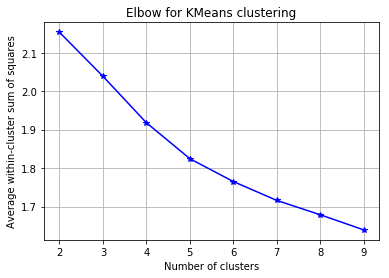

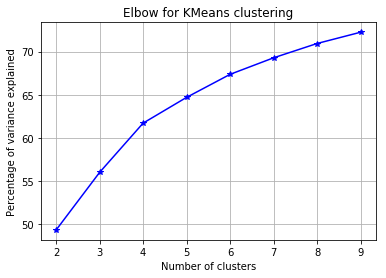

In [19]:
elbow(vals,range(2,10))

**Figure 1: Graphs of elbow for Kmeans clustering.**

**Since the graph above has a bend at 5, so I choose 5 as the number of cluster.**

In [20]:
#cluster with kmeans
km5 = KMeans(n_clusters=5, random_state=444).fit(vals)
#km_res = km.fit(vals)
vals['KM5'] = km5.fit(vals).labels_

In [21]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km5.labels_.shape

(243,)

In [22]:
#KM = pd.DataFrame(km.fit(vals).cluster_centers_)
#KM.columns = vals.columns[:]
#KM.drop('KM', axis=1,inplace=True)
#KM.head()

In [23]:
shp5 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)
shp5.head()

,ZIPCODE,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,KM5
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,...,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,4
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,...,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,4
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,...,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,4
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,...,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,4
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,...,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,4


### The map of the clusters may look something like this

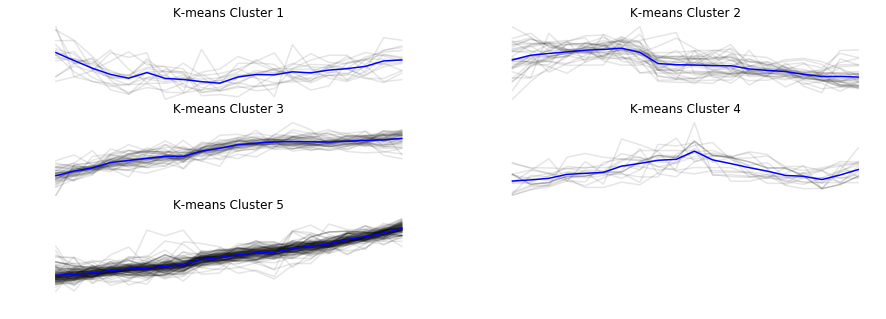

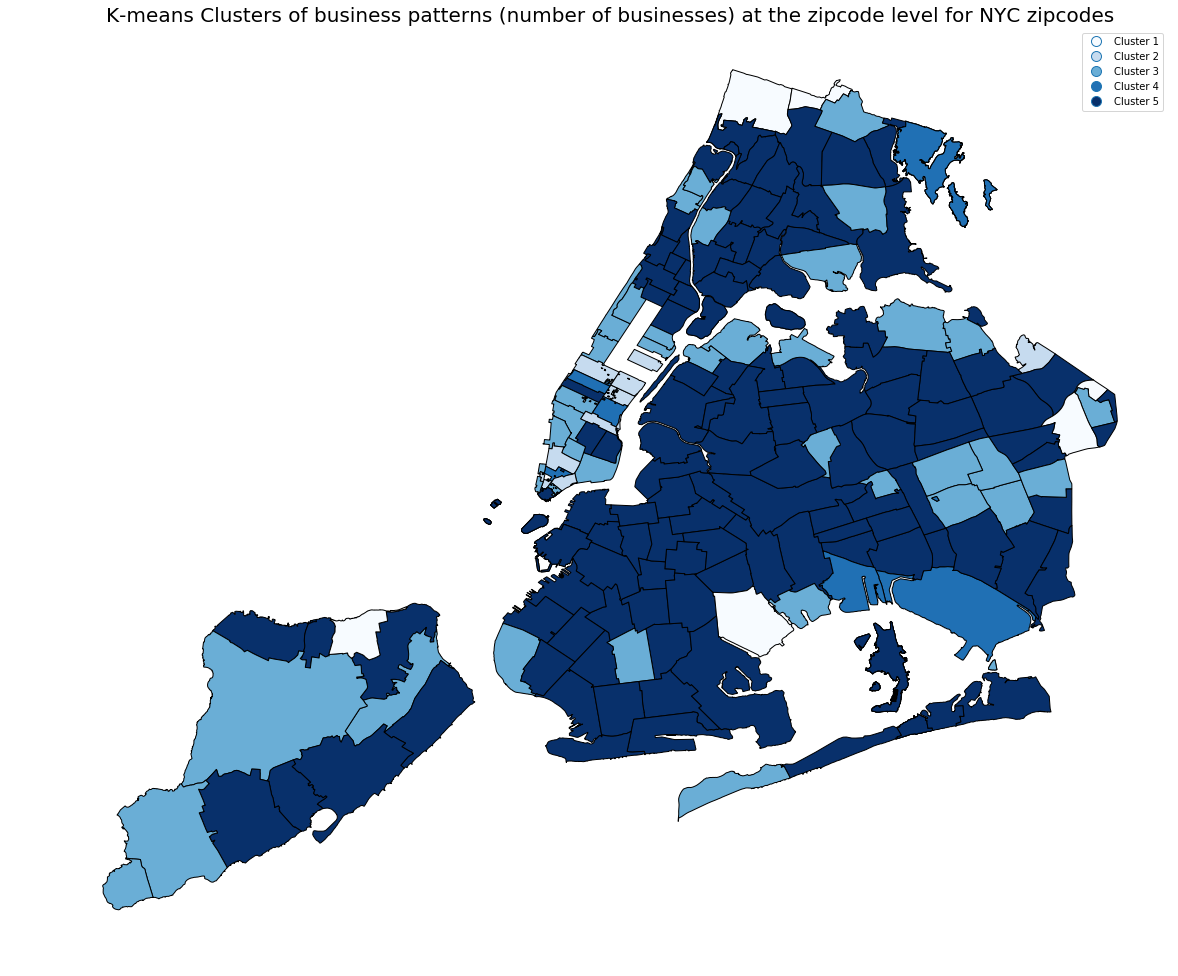

In [24]:
fig1 = plt.figure(figsize=(15,5))
for n in range(5):
    ax1 = fig1.add_subplot(3,2,n+1)
    cluster = vals[vals['KM5'] == n]
    ax1.plot(cluster.iloc[:,:-2].T, c='black', alpha=0.1)
    ax1.plot(cluster.iloc[:,:-2].mean(), c='b')
    ax1.set_title("K-means Cluster {}".format(str(n+1)))
    ax1.axis('off')


fig2 = plt.figure(figsize=(20,17))
ax2 = fig2.add_subplot(111)
shp5.plot(ax=ax2, column='KM5', cmap='Blues', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('K-means Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes',fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')
leg.get_texts()[2].set_text('Cluster 3')
leg.get_texts()[3].set_text('Cluster 4')
leg.get_texts()[4].set_text('Cluster 5')
plt.show()

**Figure 2: The 5 cluster centers overlayed on each time series and choropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.**

## Scenario 2: Using average silhouette score to find optimal k

In [25]:
# Code from Applied Data Science class session 8 by Prof. Stanislav Sobolevsky
range_n_clusters = range(2,11)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=444)
    cluster_labels = clusterer.fit_predict(vals)
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(vals, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.55229827649
For n_clusters = 3 The average silhouette_score is : 0.52971540626
For n_clusters = 4 The average silhouette_score is : 0.383835170798
For n_clusters = 5 The average silhouette_score is : 0.380615535765
For n_clusters = 6 The average silhouette_score is : 0.380079272479
For n_clusters = 7 The average silhouette_score is : 0.369895170731
For n_clusters = 8 The average silhouette_score is : 0.369820748303
For n_clusters = 9 The average silhouette_score is : 0.341787675234
For n_clusters = 10 The average silhouette_score is : 0.326813655135


**Since when n_cluster=2,the average silhouette score reaches its maximum, so I choose k=2 at this time.**

In [26]:
#cluster with kmeans
km2 = KMeans(n_clusters=2, random_state=444).fit(vals)
#km_res = km.fit(vals)
vals['KM2'] = km2.fit(vals).labels_

In [27]:
shp2 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)
shp2.head()

,ZIPCODE,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,KM5,KM2
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,...,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,4,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,...,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,4,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,...,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,4,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,...,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,4,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,...,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,4,0


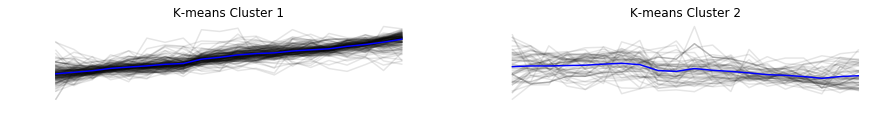

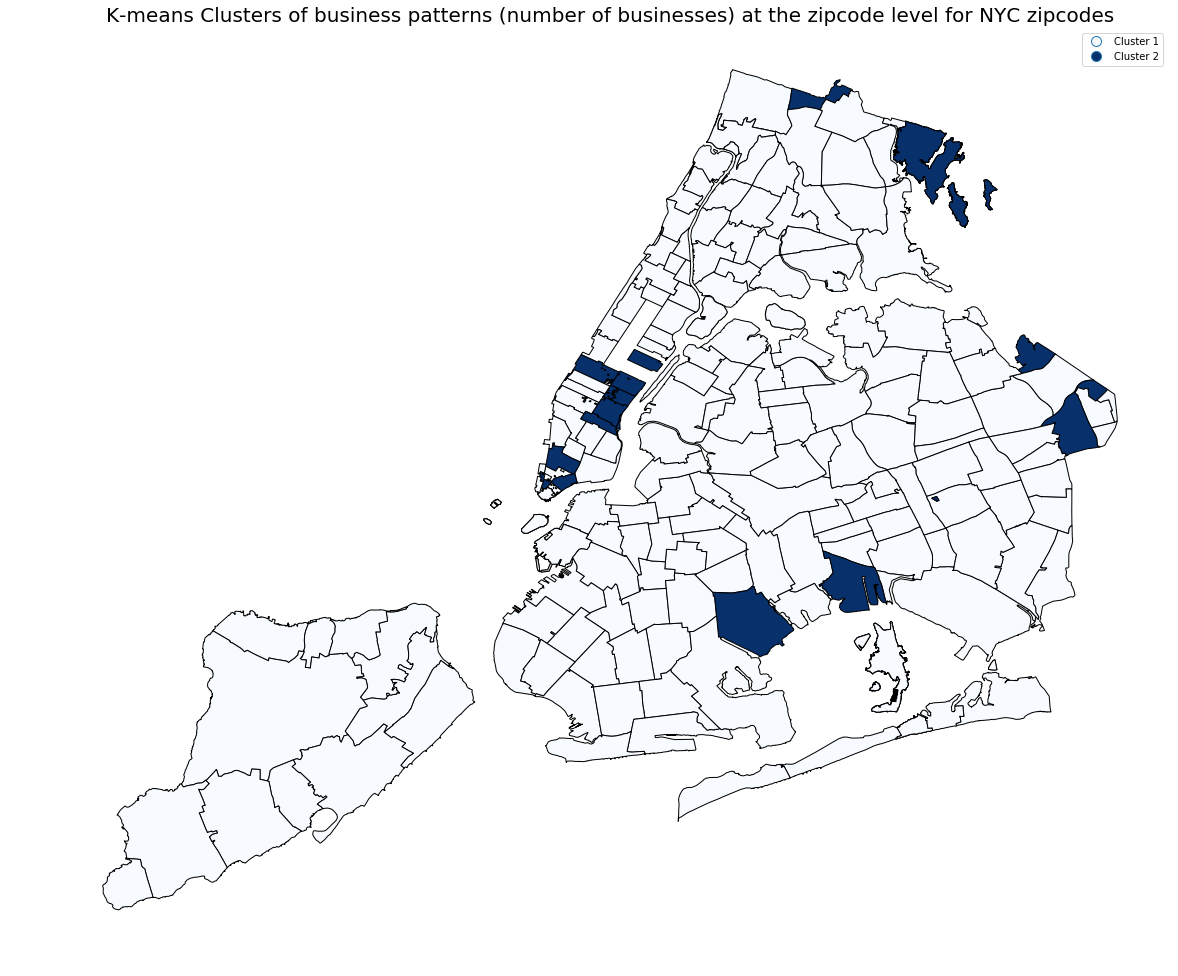

In [28]:
fig = plt.figure(figsize=(15,5))

for n in range(2):
    ax = fig.add_subplot(3,2,n+1)
    cluster = vals[vals['KM2'] == n]
    ax.plot(cluster.iloc[:,:-3].T, c='black', alpha=0.1)
    ax.plot(cluster.iloc[:,:-3].mean(), c='b')
    ax.set_title("K-means Cluster {}".format(str(n+1)))
    ax.axis('off')


fig2 = plt.figure(figsize=(20,17))
ax2 = fig2.add_subplot(111)
shp2.plot(ax=ax2, column='KM2', cmap='Blues', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('K-means Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes',fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')
plt.show()

**Figure 3: The 2 cluster centers overlayed on each time series and choropleth of cluster centers for 2 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.**

## Scenario 3: Random guess, I want to try k=9 at this time

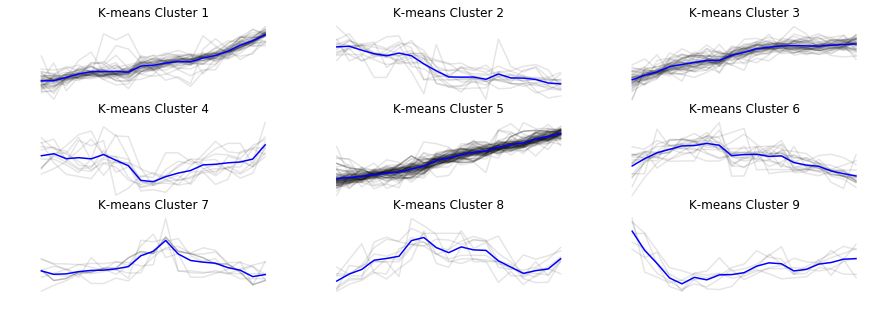

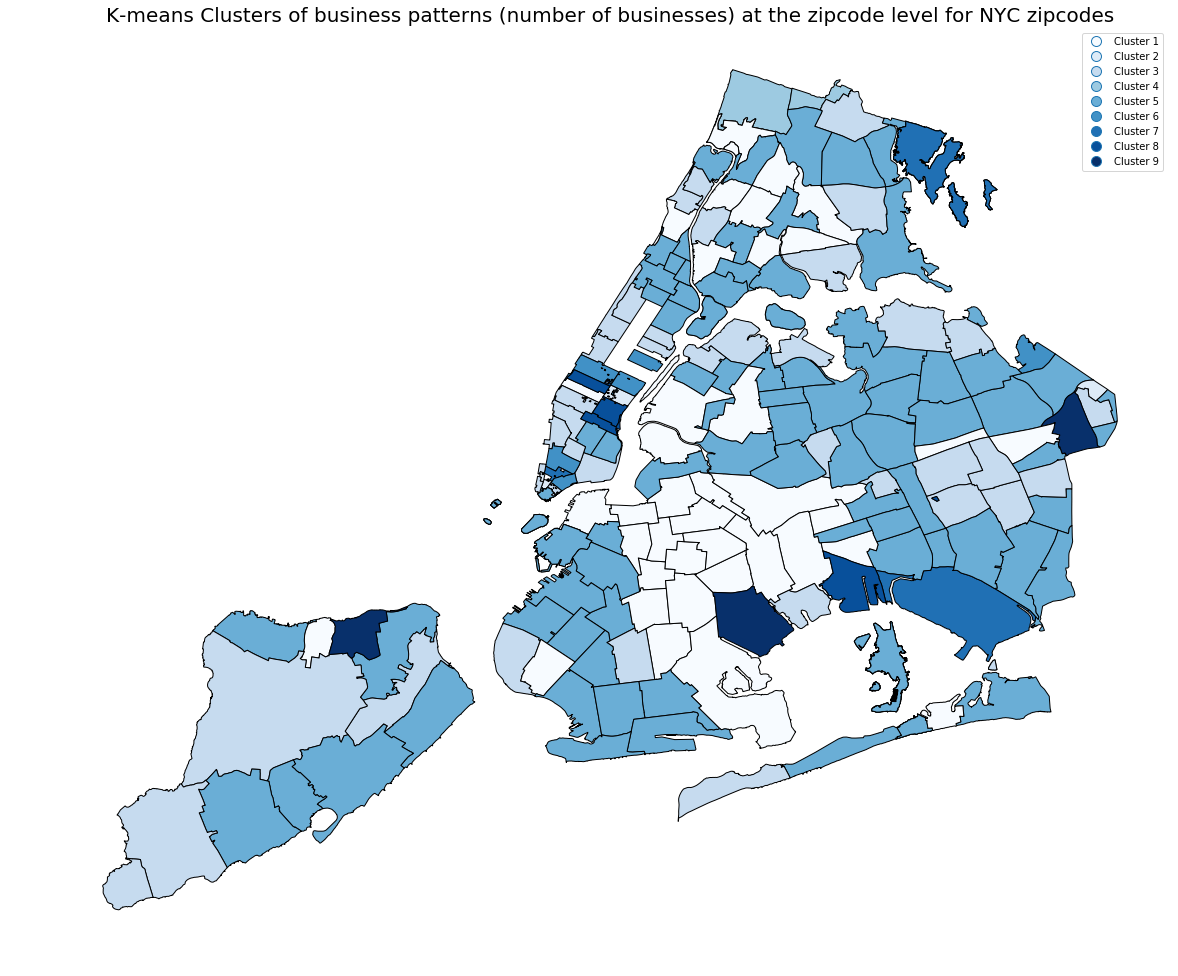

In [29]:
#cluster with kmeans
km9 = KMeans(n_clusters=9, random_state=444).fit(vals)
#km_res = km.fit(vals)
vals['KM9'] = km9.fit(vals).labels_

shp9 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)
shp9.head()

fig = plt.figure(figsize=(15,5))

for n in range(9):
    ax = fig.add_subplot(3,3,n+1)
    cluster = vals[vals['KM9'] == n]
    ax.plot(cluster.iloc[:,:-5].T, c='black', alpha=0.1)
    ax.plot(cluster.iloc[:,:-5].mean(), c='b')
    ax.set_title("K-means Cluster {}".format(str(n+1)))
    ax.axis('off')


fig2 = plt.figure(figsize=(20,17))
ax2 = fig2.add_subplot(111)
shp9.plot(ax=ax2, column='KM9', cmap='Blues', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('K-means Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes',fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')
leg.get_texts()[2].set_text('Cluster 3')
leg.get_texts()[3].set_text('Cluster 4')
leg.get_texts()[4].set_text('Cluster 5')
leg.get_texts()[5].set_text('Cluster 6')
leg.get_texts()[6].set_text('Cluster 7')
leg.get_texts()[7].set_text('Cluster 8')
leg.get_texts()[8].set_text('Cluster 9')
plt.show()

**Figure 4:  The 9 cluster centers overlayed on each time series and choropleth of cluster centers for 9 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.**

# Hierarchical clustering

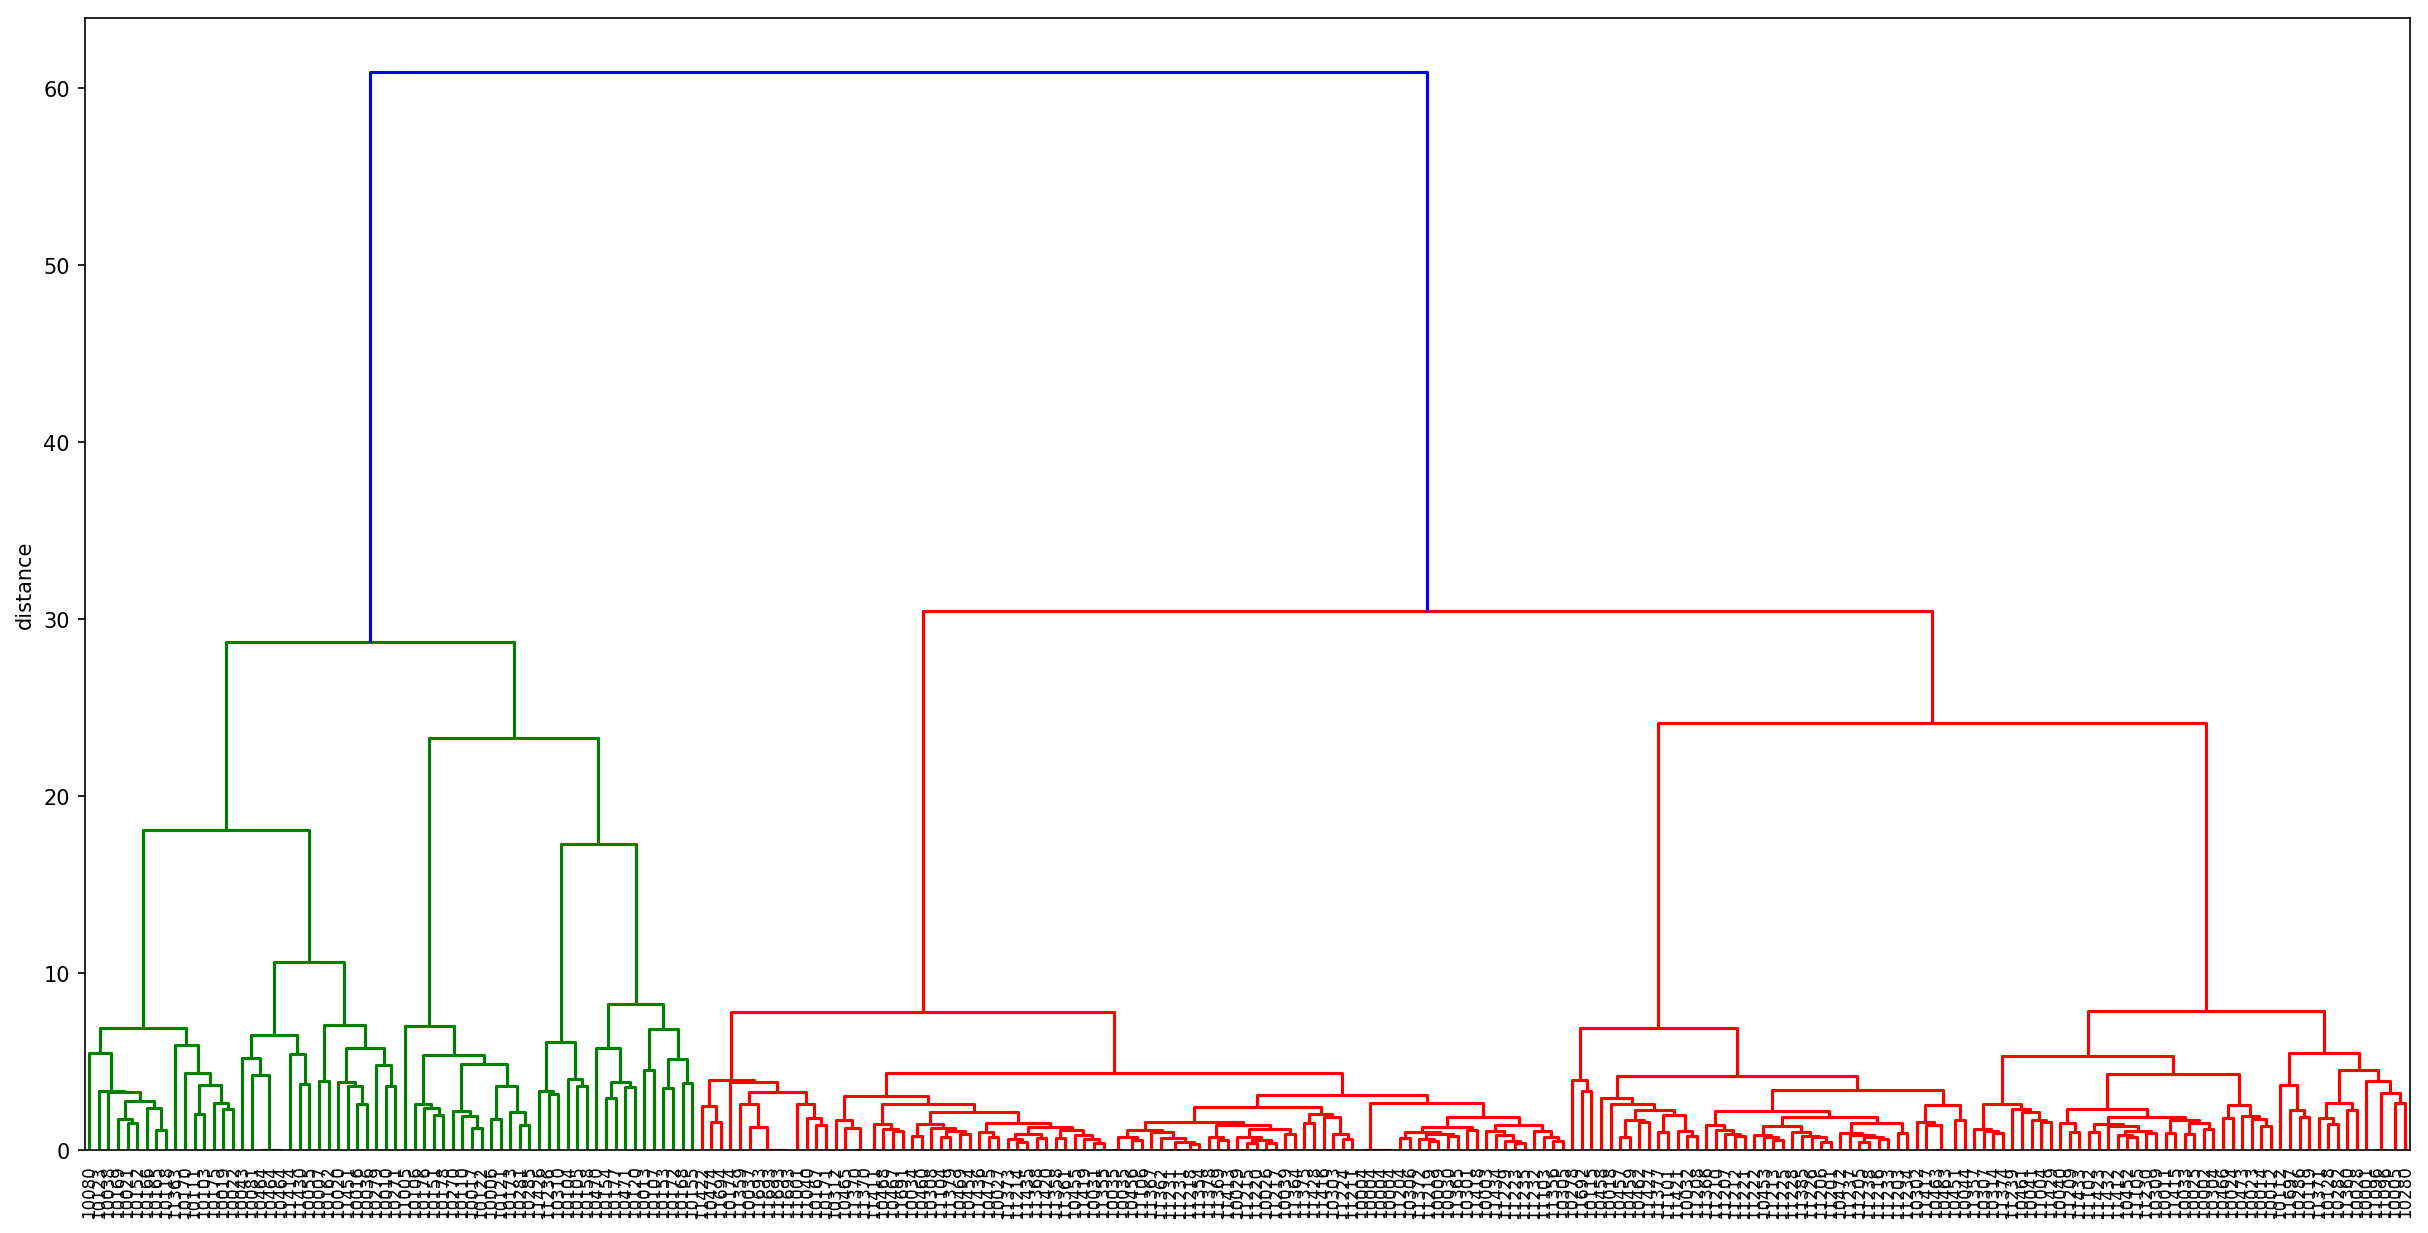

In [30]:
import scipy.cluster as scp
fig = plt.figure(figsize=(20,10), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = vals.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels
plt.show()

**Figure 5: Hierarchical clustering plot of business establishment in New York City. The figure indicates that there are 2 main clusters with the color of green and red.**

## k=2 based on the dandrogram

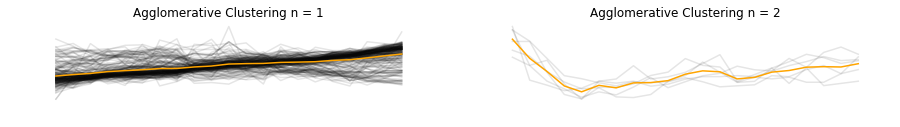

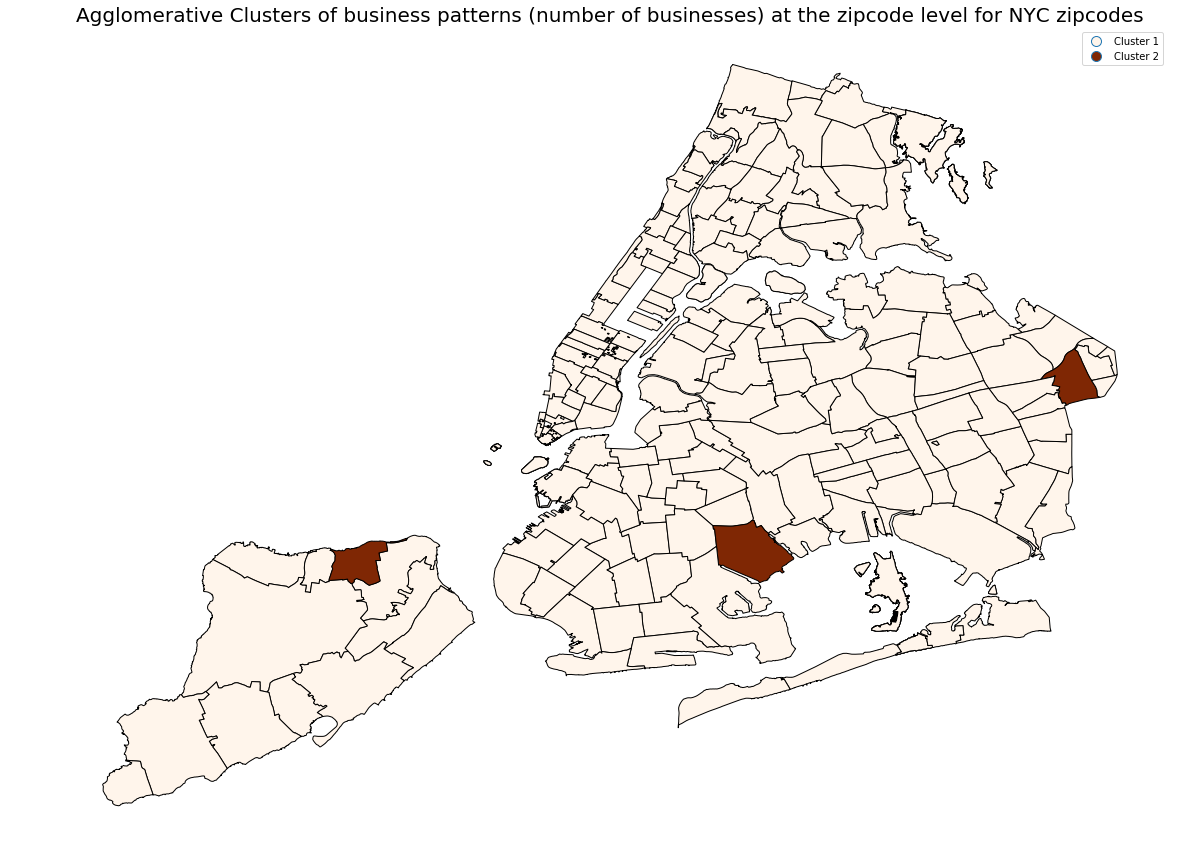

In [32]:
agc2 = AgglomerativeClustering(n_clusters=2, compute_full_tree=True, linkage='average').fit(vals)
labelsag = agc2.labels_
#centroidsag = np.zeros((5, vals.shape[1]))
vals['AGC2']=labelsag

shpp2 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)

fig = plt.figure(figsize=(15,5))
for n in range(2):
    ax = fig.add_subplot(3,2,n+1)
    cluster = vals[vals['AGC2'] == n]
    ax.plot(cluster.iloc[:,:-5].T, c='black', alpha=0.1)
    ax.plot(cluster.iloc[:,:-5].mean(), c='orange')
    ax.set_title("Agglomerative Clustering n = {}".format(str(n+1)))
    ax.axis('off')
    

fig2 = plt.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

shpp2.plot(ax=ax2, column='AGC2', cmap='Oranges', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('Agglomerative Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes', fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')

plt.show()

**Figure 6: The 2 cluster centers overlayed on each time series and choropleth of cluster centers for 2 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.**

## K=5 using elbow

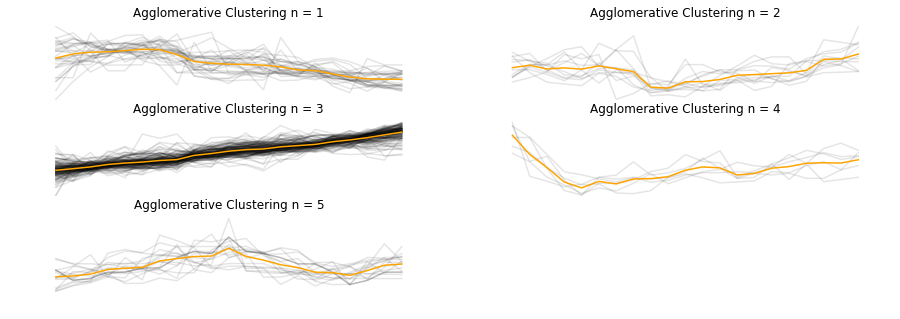

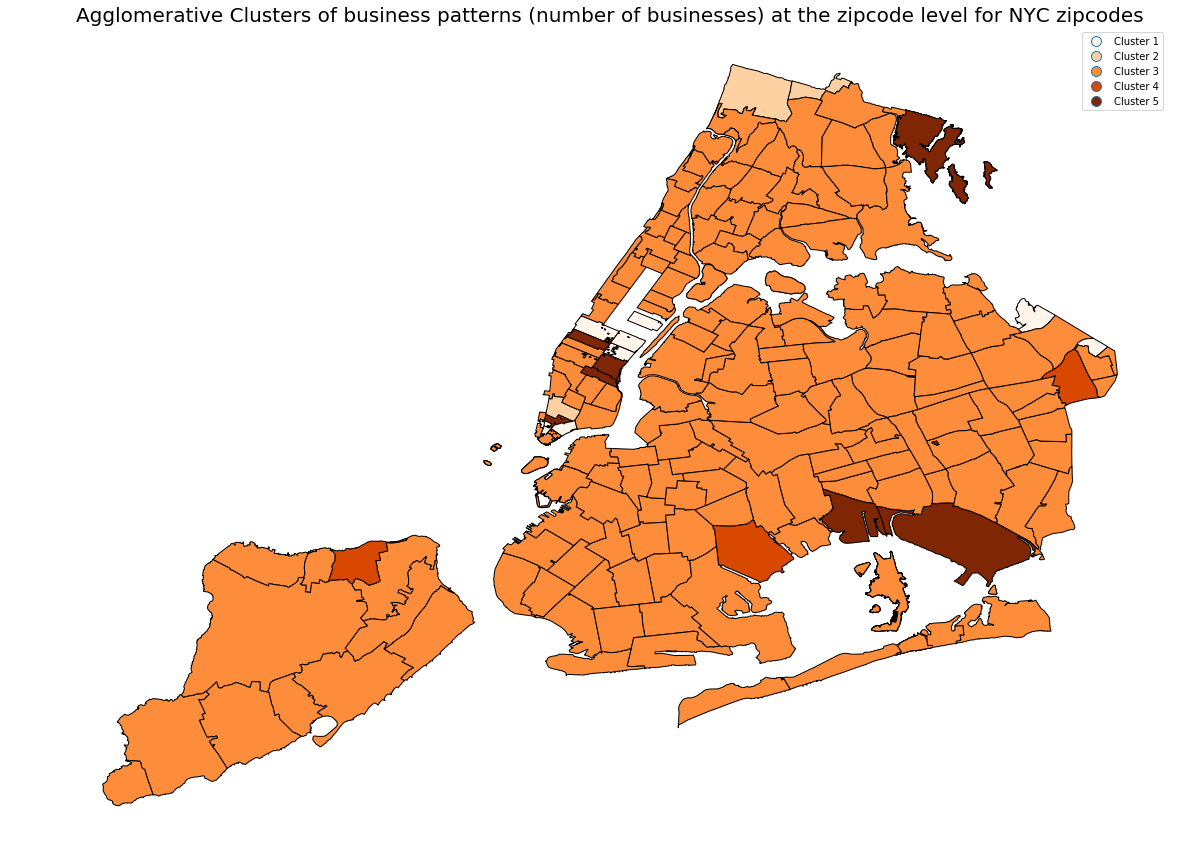

In [31]:
agc5 = AgglomerativeClustering(n_clusters=5, compute_full_tree=True, linkage='average').fit(vals)
labelsag = agc5.labels_
#centroidsag = np.zeros((5, vals.shape[1]))
vals['AGC5']=labelsag

shpp5 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)

fig = plt.figure(figsize=(15,5))
for n in range(5):
    ax = fig.add_subplot(3,2,n+1)
    cluster = vals[vals['AGC5'] == n]
    ax.plot(cluster.iloc[:,:-4].T, c='black', alpha=0.1)
    ax.plot(cluster.iloc[:,:-4].mean(), c='orange')
    ax.set_title("Agglomerative Clustering n = {}".format(str(n+1)))
    ax.axis('off')
    

fig2 = plt.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

shpp5.plot(ax=ax2, column='AGC5', cmap='Oranges', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('Agglomerative Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes', fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')
leg.get_texts()[2].set_text('Cluster 3')
leg.get_texts()[3].set_text('Cluster 4')
leg.get_texts()[4].set_text('Cluster 5')

plt.show()

**Figure 7: The 5 cluster centers overlayed on each time series and choropleth of cluster centers for 5 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top**

## k=9 using random guess

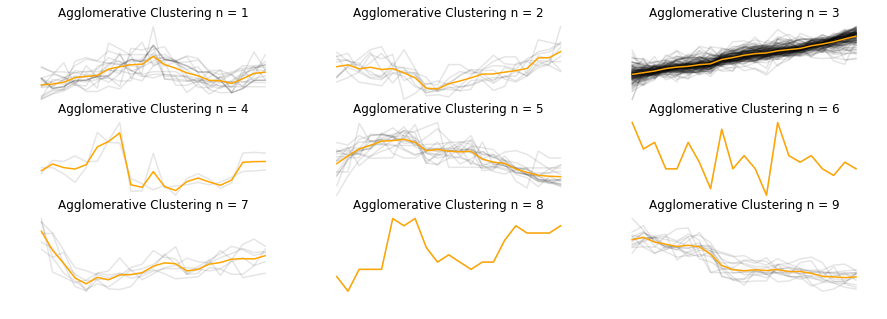

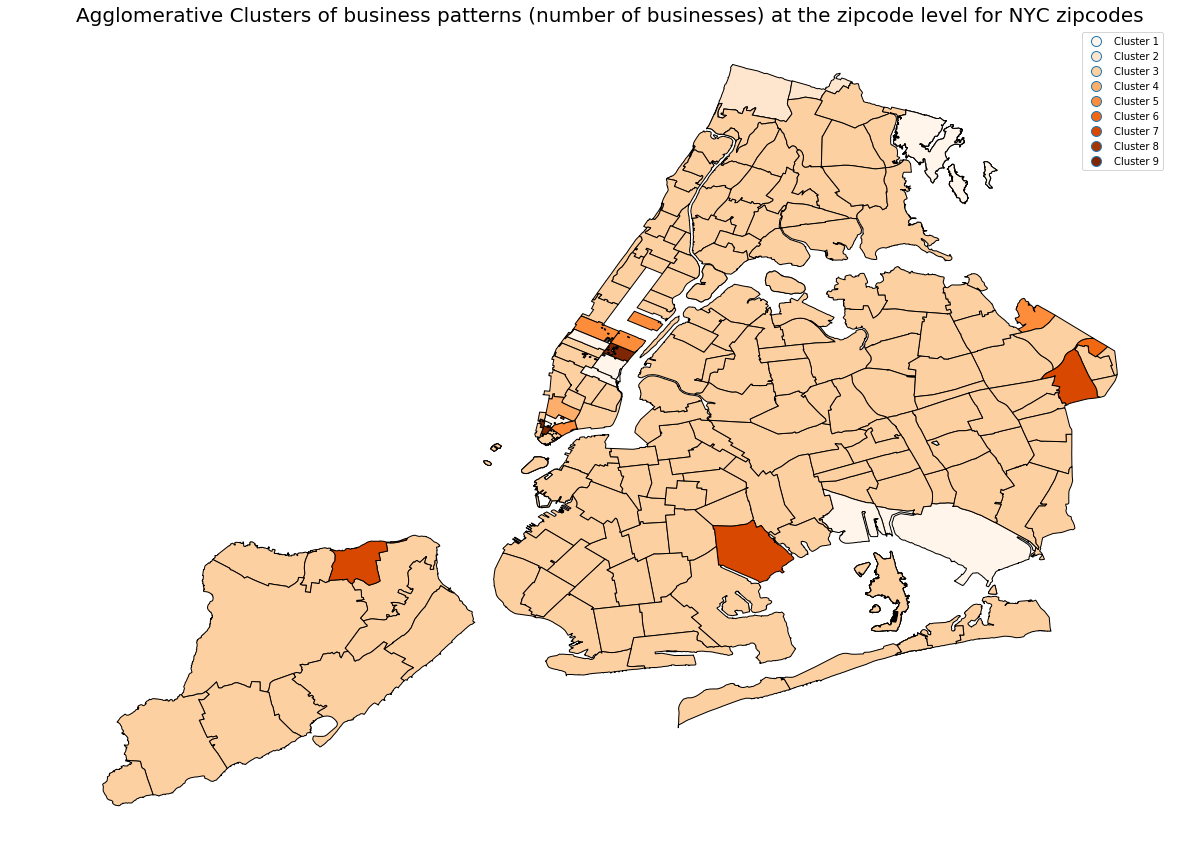

In [38]:
agc9 = AgglomerativeClustering(n_clusters=9, compute_full_tree=True, linkage='average').fit(vals)
labelsag = agc9.labels_
vals['AGC9']=labelsag

shpp9 = nyczipsshp.merge(vals, left_on='ZIPCODE', right_index=True)

fig = plt.figure(figsize=(15,5))
for n in range(9):
    ax = fig.add_subplot(3,3,n+1)
    cluster = vals[vals['AGC9'] == n]
    ax.plot(cluster.iloc[:,:-6].T, c='black', alpha=0.1)
    ax.plot(cluster.iloc[:,:-6].mean(), c='orange')
    ax.set_title("Agglomerative Clustering n = {}".format(str(n+1)))
    ax.axis('off')
    

fig2 = plt.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

shpp9.plot(ax=ax2, column='AGC9', cmap='Oranges', edgecolor='k', lw=1, legend=True, categorical=True)
ax2.set_title('Agglomerative Clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes', fontsize=20)
ax2.axis('off')
leg = ax2.get_legend()
leg.get_texts()[0].set_text('Cluster 1')
leg.get_texts()[1].set_text('Cluster 2')
leg.get_texts()[2].set_text('Cluster 3')
leg.get_texts()[3].set_text('Cluster 4')
leg.get_texts()[4].set_text('Cluster 5')
leg.get_texts()[5].set_text('Cluster 6')
leg.get_texts()[6].set_text('Cluster 7')
leg.get_texts()[7].set_text('Cluster 8')
leg.get_texts()[8].set_text('Cluster 9')

plt.show()

**Figure 8: The 9 cluster centers overlayed on each time series and choropleth of cluster centers for 9 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.**

# Compare the results of the 2 algorithms

- Kmeans are not stable as the number of cluster change. k changed from 2 to 5 to 9, the proportion of each clusters are relatively even compare to agglomerative clustering.
- Since from the dandrogram, there are only 2 main clusters with one group has the majority of the samples and others has a very smaller count. So even when k=9, from the graph we can see that group 4 has the most part of the NYC and other groups distributed at the very corner of the city.
- In addition, from the result of the average silhouette coefficient and the dandrogram, the optimal number of cluster is 2. This might indicates that this dataset is not very suitable for clustering. But this might because I did not manage the data well at the begining.

# Interpretation

- The general trend based on the above 6 clustered maps shows that these two algorithms are does not differ that much. The difference of these two algorithms may caused by the randomness. And the kmeans results are also depend on the number of clusters. 
- From the maps we can see most of the zipcode regions follow the same pattern over the years. However the small part of the zipcodes have different patterns. We can see the upper part of Staten Island around Snug Harbor Cultural Center, east part of brooklyn around east new york, and east part of Queens around Douglaston are always at the same group. This might because of their economy taking off and relatively density population around those locations.
- As far as cluster variety goes, there's a distinction at lower Manhattan, which would make sense since it is the CBD of new york.